# Explainable AI (XAI) Techniques: Developing Feature Prototype


In [7]:
# Mount the Google Drive for access to datasets stored on Colab Pro
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Import required libraries

# Import general libraries for data analysis and visualiztion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

# Enables passing functions with parameters for inputs for SHAP explainer
from functools import partial

# Import scikit-learn imports for train test splitting,feature extraction, machine-learning models and evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
# Functionality for handling sparse TF-IDF matrix for SHAP
from scipy import sparse

# Import libraries for explainable AI techniques
!pip install lime
!pip install shap
!pip install alibi
import lime
import lime.lime_text
import shap

import shap
import pandas as pd
import numpy as np

## Experiments using LIME on the WELFake Dataset to Explain Predictions Generated with Passive-Aggressive Classifier and TF-IDF Feature Vectorization

### Preparing Dataset for Explainability Pipeline

In [9]:
# Load in the pre-processed WELFake dataset as a pandas DataFrame
welfake_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/preprocessed_welfake.csv")

# Split dataset into text samples (featuresets) + fake/real labels/targets
X = welfake_df['text']
y = welfake_df['label']

# Split the data into train-test sets with 80-20 split. Use random_state = 5 for reproducibility because the dataset is shuffled randomly here.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## Helper Functions for Exploring XAI Techniques

In [10]:
# Displays results for classification on a specific dataset
def classifierEvaluation(y_test, y_pred, average_type="macro", cmap="viridis"):
  """
    Conducts evaluation of classifier performance using multiple metrics and by visualizing a confusion matrix.
    Input parameters:
      y_test: set of true labels for classification task - 0 = real, 1 = fake news
      y_pred: set of predicted labels
      average_type: whether to use macro or micro F1/precision/recall score (macro is recommended for imbalanced datasets)
      cmap: a string specifying the color map for visualization with the confusion matrix heatmap
    Outputs:
      dict: contains the scores for 4 metrics (accuracy, precision, recall, F1-score)
  """

  # Calculate basic performance metrics using real and predicted labels
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average=average_type)
  recall = recall_score(y_test, y_pred, average=average_type)
  macro_f1 = f1_score(y_test, y_pred, average=average_type)

  # Log the results
  print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision (Macro): {precision:.4f}')
  print(f'Recall (Macro): {recall:.4f}')
  print(f'Macro F1-score: {macro_f1:.4f}')

  # Print the scikit-learn classification report
  print("\nClassification Report:\n")
  print(classification_report(y_test, y_pred))

  # Generate a confusion matrix using the scikit-learn function
  c_matrix = confusion_matrix(y_test, y_pred)

  # Visualize the confusion matrix using a color-coded Seaborn heatmap
  plt.figure(figsize=(6, 5)) # Set plot size
  # Heatmap parameters: c_matrix = the confusion matrix, annot=True means show prediction conunts, fmt='d' means show counts as integers, cmap = color scheme
  sns.heatmap(c_matrix, annot=True, fmt='d', cmap=cmap,
            xticklabels=['real', 'fake'], yticklabels=['real', 'fake']) # 0 = real, 1 =fake
  # Add labels and title to the confusion matrix to enable comparison between ground truth labels and predicted labels
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'macro_f1': macro_f1}

# Function to output interpretations for a prediction generated using LIME
# Link to documentation: https://lime-ml.readthedocs.io/en/latest/lime.html#subpackages
# Link to description of the algorithm: "What is Local Interpretable Model-Agnostic Explanations (LIME)?" https://c3.ai/glossary/data-science/lime-local-interpretable-model-agnostic-explanations/
def generateLIMEExplanation(pipeline, X_train, example_index, num_features=30):
    """
      Uses LIME: Local Interpretable Model-Agnostic Explanations to generate explanations for which text features (words) were most important for a prediction.
      "lime.lime_text.LimeTextExplainer" explains text classifiers.
      From the docs: "Currently, we are using an exponential kernel on cosine distance, and restricting explanations to words that are present in documents."

      Input Parameters:
        pipeline (scikit-learn Pipeline): a pre-trained scikit-learn pipeline object combining vectorization and any ML models applied to the vectorized dataset
        X_train (pd.Series): training data news samples
        example_index (int): the index of the example news article to be explained to users
        num_features (int): number of top most predictive words/features to output in LIME explanation

      Outputs:
        explanation (lime.explanation.Explanation object): the whole LIME explanation object for the prediction
        explanation.as_list() (list of tuples): each tuple contains the predictive word and a score (-1 to 1) explaining how much the word contributed to the overall prediction

    """
    # Instantiate a Text Explainer object from LIME specially for explaining which text features (words/tokens) contribute most to the prediction
    explainer = lime.lime_text.LimeTextExplainer(class_names=['real', 'fake']) # 0 = real, 1 = fake; Ref: https://medium.com/@carmenscartezini/fake-news-classification-tensorflow-x-pytorch-2a8f471a3713

    # Select the sample for explanation using .loc to index into DataFrame with index
    sample = X_train.loc[example_index]

    # Explain the prediction for this samples using the pipeline containing the CalibratedClassifierCV model to wrap the Passive Aggressive Classifier to output probabilities
    explanation = explainer.explain_instance(sample, pipeline.predict_proba, num_features=num_features)

    # Visualize the explanation in this Jupyter Notebook
    explanation.show_in_notebook()

    # Return the explanation object and the list of tuples showing informativity scores for each words
    return explanation, explanation.as_list()

def findNewsDocInPreprocessedDataset(data_series, example_text):
  """
    Takes the beginning of a news text and finds its corresponding index in a pandas Series (either X_train or X_test)

    Input Parameters:
      example_text (str): the preprocessed text to search for in the Series
      data_series (pd.Series): the pandas Series to search through to find the index of this news text (useful after shuffing DataFrame into train and test splits)

    Output:
      matching_indices (pandas Index): the list of indices which match the example text
  """
  # Find the row index in X_train where the news text begins with the string above
  matching_indices = data_series[data_series.str.startswith(example_text)].index

  # Display the matching row using the found index above
  matching_rows = data_series.loc[matching_indices]
  print(f"Number of matching rows: {len(matching_rows)}")
  print(f"Matching rows:\n{matching_rows}")

  return matching_indices

def findNewsDocInOriginalDataset(original_df, search_keywords):
  """
    Takes a list of keywords from a preprocessed news text and finds either the index of the preprocessed text or original unprocessed news text
    in the original dataset. This is required because of the requirement of presenting the original text to users for user testing.

    Input Parameters:
      original_df (pd.DataFrame): original, unprocessed news samples DataFrame
      search_keywords (list): a list of strings/keywords to look for in the original DataFrame to find the original article

    Output:
      matching_indices (list): a list of integers representing indices of matching rows in the original DataFrame
  """
  # Copy the original (unprocessed text) DataFrame into a temp variable called 'matched rows' that will eventually store the doc rows matching the keywords
  matched_rows = original_df.copy()

  # Filter the rows in the original DataFrame to find only the rows matching *all* of the keywords (equivalent to a logical AND condition)
  for keyword in search_keywords:
    # Use a mask to extract only the rows where the news text contains a certain keyword, discards the other original DataFrame rows.
    # Use case=False to make search case-insensitive because the unpreprocessed data is not yet lowercased. Use na=False to handle rows containing NaN by ignoring them.
    matched_rows = matched_rows[matched_rows['text'].str.contains(keyword, case=False, na=False)]

  # Extract the original dataset indices of the located original articles
  matching_indices = matched_rows.index

  # Print the number of matching rows
  print(f"\n\nNumber of matches found: {len(matching_indices)}")

  # Adjust pandas display to show more of the news text
  pd.set_option('display.max_colwidth', 2000)

  # Print the original dataset matching rows with their indices using .iloc to find these indices and : to print all the columns
  print(f"Matching rows: {original_df.iloc[matching_indices, :]}\n\n")

  # Return the list of matching indices to make it easy to find the desired article in its original form
  return matching_indices

#### Testing the Function for Locating Original News Text in Unprocessed WELFake Dataset based on Keywords from Preprocessed News Text

In [14]:
"""
  Testing the findOriginalNewsDoc function with an example news text from the preprocessed X_train.
  Trying to find the original text in the WELFake DataFrame, as the indices are different in the preprocessed dataset due to removal of non-English and NaN rows.
"""

# Load in the original, unpreprocessed dataset
original_welfake_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/welfake.csv")

# Choose a random pre-processed, tokenized, lowercased sample from the X_train news texts for which it's necessary to find the original news article
example_text = X_train.iloc[19]
print(f"Preprocessed text to find: '{example_text[0:500]}'")

# Get first 20 words of the preprocessed text as keywords using .split() to split on whitespace from string to list
keywords = example_text.split()[0:20]
print(f"\nKeywords to search for: {keywords}")

# Apply the search function to find the indices matching the keywords
matching_indices = findNewsDocInOriginalDataset(original_welfake_df, keywords)

print(f"\nMatching indices in original dataset: {matching_indices}")

Preprocessed text to find: 'anyone else find strange obama would lobby hard make easy iran develop nuclear weapon likely use u ally middle east maybe aware dealing country actual day set aside celebrate hate america israel iran quds day death america death israelthe ritualistic rally cry death america death israel quds day become day iran protestors society attack legitimacy state israel little satan continue threaten united state big satan gatestone institute apparent draft one secret side agreement iran nuclear deal indi'

Keywords to search for: ['anyone', 'else', 'find', 'strange', 'obama', 'would', 'lobby', 'hard', 'make', 'easy', 'iran', 'develop', 'nuclear', 'weapon', 'likely', 'use', 'u', 'ally', 'middle', 'east']


Number of matches found: 3
Matching rows:        Unnamed: 0  \
16002       16002   
26838       26838   
45724       45724   

                                                                                                                title  \
16002  INSANE: SEC

From this, it's possible to see that the news text matches two (duplicate) entries at index 16002 and 45724 in the original dataset, which can then be extracted from *original_welfake_df* using the *.iloc* function to display the news text in its original form to users for testing in the surveys.

Now this has been verified to function correctly, the next stage is to apply the LIME explanation function to a particular example news text for user testing.

In [15]:
# Examine the first 200 lines of the X_train text data to find an example news text for testing with users
for index, (text, label) in enumerate(zip(X_train, y_train)):
    print(index, text[:100], label)  # Show only the first 100 characters in the text. Remember: label = 1 means fake news.
    if index > 200:  # Stop after 200 news texts
        break

0 phnom penh reuters cambodian prime minister hun sen encouraged united state european union friday fr 0
1 well ironic joe biden one worst come getting space happen female sure best person introduce song yet 1
2 new yorkwashington reuters president donald trump said friday obamacare exploding republican lawmake 0
3 new york reuters democratic presidential candidate hillary clinton held percentagepoint lead republi 0
4 fake news november exclusive pushback coming internet success giving world access diverse opinion di 1
5 new york reuters democratic presidential candidate bernie sander accused frontrunner hillary clinton 0
6 shanghai reuters chinese president xi jinping vast belt road infrastructure project unexpectedly inc 0
7 san diego last line defense torrent untruth outright fakery make much modern internet downscale stri 0
8 tallinn reuters french president emmanuel macron said friday european union leader agreed summit din 0
9 washington cnn donald trump attempting crack hillary 

In [16]:
# Having inspected some examples, then choose text starting with "one woman awful experience airport could soon go travel air day terrorism islamist pretty much"
# This seems like a good example of fake news due to emotional sensational language, e.g. 'awful experience'
example_text = "one woman awful experience airport could soon go travel air day terrorism islamist pretty much"

# Find the row index in X_train where the news text begins with the string above
matching_indices = findNewsDocInPreprocessedDataset(X_train, example_text)

Number of matching rows: 1
Matching rows:
4600    one woman awful experience airport could soon go travel air day terrorism islamist pretty much anything hide explosive weapon endure intimate examination order keep u safe flying new procedure put place month agoplease see specific story tell like hear jenna story belowjenna macfarlane way visit friend baltimore april carryon bag triggered alarm charlotte transportation security administration screener told macfarlane would undergo fullbody patdown female officer late flight option searched private macfarlane patdown done clothes explored breast crotch buttock imagine would ask time spread leg wider fact touch vagina four time side hand macfarlane later wrote complaint month search tsa launched new involved patdown procedurepatdown procedure used determine whether prohibited item threat transportation security concealed person may required undergo patdown procedure screening technology alarm part random unpredictable security measure en

In [17]:
# Extract the news text at index 4600 in X_train for user testing
preprocessed_example_text = X_train[4600]
print(preprocessed_example_text[0:250])

# Extract a few of the keywords from this sample text
keywords = example_text.split()[0:20]
print(f"\nKeywords to search for: {keywords}")

# Find the original version of this text now in the WELFake unprocessed dataset using the search function
matching_indices = findNewsDocInOriginalDataset(original_welfake_df, keywords)
print(f"\nMatching indices in original dataset: {matching_indices}")

# Get matching news text out (index 4754)
original_example_text = original_welfake_df.loc[4754, 'text']
# Print the original example text
print("\nOriginal news text:", original_example_text)

one woman awful experience airport could soon go travel air day terrorism islamist pretty much anything hide explosive weapon endure intimate examination order keep u safe flying new procedure put place month agoplease see specific story tell like he

Keywords to search for: ['one', 'woman', 'awful', 'experience', 'airport', 'could', 'soon', 'go', 'travel', 'air', 'day', 'terrorism', 'islamist', 'pretty', 'much']


Number of matches found: 2
Matching rows:        Unnamed: 0  \
4754         4754   
24883       24883   

                                                                                        title  \
4754   AIRPORT PASSENGER “PAT DOWNS” Get More Intrusive With New Full-Body Groping Procedures   
24883  AIRPORT PASSENGER “PAT DOWNS” Get More Intrusive With New Full-Body Groping Procedures   

                                                                                                                                                                                       

In [11]:
# View the preprocessed text example
X_train.loc[4600]

'one woman awful experience airport could soon go travel air day terrorism islamist pretty much anything hide explosive weapon endure intimate examination order keep u safe flying new procedure put place month agoplease see specific story tell like hear jenna story belowjenna macfarlane way visit friend baltimore april carryon bag triggered alarm charlotte transportation security administration screener told macfarlane would undergo fullbody patdown female officer late flight option searched private macfarlane patdown done clothes explored breast crotch buttock imagine would ask time spread leg wider fact touch vagina four time side hand macfarlane later wrote complaint month search tsa launched new involved patdown procedurepatdown procedure used determine whether prohibited item threat transportation security concealed person may required undergo patdown procedure screening technology alarm part random unpredictable security measure enhanced screening alternative type screening advan

#### Testing the LIME Explainer using the Example News Text


In [22]:
# Limit num of TF-IDF Vectorizer features to reduce dimensionality due to slowness of LIME when sparse matrices used, also use only words that appear min. of 5 times
# This helps reduce overfitting to training data based on words that might occur rarely as misspellings or other errors
# Increasing number of features leads to better predictions and LIME explanations, but takes a very long time when there were 200,000+ features originally
vectorizer = TfidfVectorizer(max_features=10000,  min_df=5)

# Instantiate the classifier with the optimal hyperparameter settings found earlier using the scikit-learn GridSearchCV  functionon this dataset
pa_model = PassiveAggressiveClassifier(C=0.1, fit_intercept=True, loss='hinge', max_iter=250, tol=0.001, random_state=5)

# Wrap the PA model in the CalibratedClassifierCV to enable conversion of decision function scores into calibrated probability predictions with five-fold cross validation
calib_model = CalibratedClassifierCV(pa_model, method='sigmoid', cv=5) # Use sigmoid function to convert decision scores (distance from margin) into probabilities

# Create a pipeline of vectorizer and model
pipeline = make_pipeline(vectorizer, calib_model)

# Train the pipeline (first vectorizes the text with TF-IDF and then fits the PAC classifier and converts scores to probabilities)
pipeline.fit(X_train, y_train)

# # Get an explanation object and list of word explanations for this text sample
explanation, explanation_as_list = generateLIMEExplanation(pipeline, X_train, example_index=4600)

# # Print the LIME explanation (list of feature scores)
print(explanation)
print(explanation_as_list)

[('screening', 0.1139470295922137), ('may', -0.07048222025278911), ('please', 0.05200523108133299), ('charlotte', 0.029961669469177603), ('wrote', -0.026170460465384897), ('pretty', 0.025903907145959026), ('inform', 0.025732481164089608), ('anything', 0.025582154608951035), ('procedure', -0.025385829113590403), ('passenger', -0.025282425518130643), ('hand', 0.025237654628585085), ('wider', -0.025021813076372145), ('islamist', -0.022525226298417626), ('month', -0.020949047598107562), ('alarm', 0.02091559246562482), ('receive', -0.019256320320700963), ('covering', -0.01871008951533081), ('additional', -0.01837036113229676), ('determine', 0.017986688085220602), ('see', 0.016495695268982223), ('go', 0.016342484981331493), ('arm', 0.015791035157196577), ('gender', 0.015484947978641537), ('sufficient', -0.015334224592174933), ('experience', -0.014766855029711838), ('request', -0.014701685269517921), ('touched', 0.014121903549927766), ('whether', -0.014044492302083506), ('undergo', 0.01383434

In [24]:
# Test another news sample
example_text2 = 'representative steve king riowa notorious racist sunday came fire xenophobic comment suggesting'
# Find the row index in X_train where the news text begins with the string above
matching_indices = findNewsDocInPreprocessedDataset(X_train, example_text2)
# # # Extract the news text at index 58690 in X_train for user testing
preprocessed_example_text2 = X_train[58690]
print(preprocessed_example_text2[0:250])

# # # Extract a few of the keywords from this sample text
keywords2 = preprocessed_example_text2.split()[10:20] # Sometimes it's necessary to experiment with keywords to find the correct text due to words changing following preprocessing

# # # Find the original version of this text now in the WELFake unprocessed dataset using the search function
matching_indices2 = findNewsDocInOriginalDataset(original_welfake_df, keywords2)
print(f"\nMatching indices in original dataset: {matching_indices2}")

# Get matching news text out (index 67817)
original_example_text2 = original_welfake_df.loc[67817, 'text']
# Print the original example text
print("\nOriginal news text:", original_example_text2)

# View the preprocessed text example
print(f"\nPreprocessed news text: {X_train.loc[58690]}")

Number of matching rows: 1
Matching rows:
58690    representative steve king riowa notorious racist sunday came fire xenophobic comment suggesting immigration bad america western civilization monday doubled comment even said nonwhite people historically contributed nothing building western civilization value king tweeted weekendwilders understands culture demographic destiny cant restore civilization somebody elses baby steve king march 2017well condemnation comment coming one surprising place fellow republican former presidential candidate florida governor relative two previous republican president jeb bush seems enough steve king racist statement jeb took twitter monday said king remark way reflect shared history value tweetamerica nation immigrant sentiment expressed steve king doesnt reflect shared history value jeb bush march 2017i never thought saying jeb bush right america nation immigrant celebrate immigration diversity difference make u stronger weaker steve king stone cold ra

In [25]:
# Now apply LIME to the new above example:

# Vectorize and fit models with pipeline
pa_model = PassiveAggressiveClassifier(C=0.1, fit_intercept=True, loss='hinge', max_iter=250, tol=0.001, random_state=5)
calib_model = CalibratedClassifierCV(pa_model, method='sigmoid', cv=5) # Use sigmoid function to convert decision scores (distance from margin) into probabilities
pipeline = make_pipeline(vectorizer, calib_model)
pipeline.fit(X_train, y_train)
# Get explanations from lime text explainer
explanation, explanation_as_list = generateLIMEExplanation(pipeline, X_train, example_index=58690)
# Print the LIME explanations
print(explanation_as_list)

[('civilization', 0.21527812784964914), ('via', 0.20896328724355975), ('image', 0.19480334760295756), ('racist', 0.14461815996307456), ('monday', -0.09041278771071044), ('said', -0.07634350096841502), ('please', 0.06932058404968658), ('twitter', -0.06187674859226336), ('bush', -0.0534914959437653), ('jeb', -0.04776041827192521), ('comment', 0.04714474729466668), ('march', -0.046995277536042386), ('king', -0.04428617041134178), ('relative', -0.04345076696839117), ('doesnt', -0.0421446020968393), ('destiny', -0.04095529154624611), ('contributed', -0.04071348214057077), ('value', -0.03988022807788055), ('shared', -0.03440338662621785), ('contempt', -0.034065393293956366), ('cant', -0.032703287215007884), ('sunday', -0.032349547961183125), ('remark', -0.03129592437002896), ('belong', 0.03028457234189134), ('surprising', 0.02938296038214626), ('reflect', -0.028227710203569577), ('sean', 0.027808076652734447), ('america', 0.026058154963972652), ('notorious', 0.021166504752569468), ('thought'

#### Testing the SHAP Explainer using the Example News Text


In [30]:
# Functions for Calculating and Displaying SHAP Explanations

def vectorizeSamples(X_train, X_test, max_features=8000, min_df=5):
  """
    Vectorize train and test news samples with TF-IDF vectorizer

    Input Parameters:
      X_train (pd.Series): series of news texts for the training set
      X_test (pd.Series): series of news texts for test set
      max_features (int): maximum number of features (words) to encode with TF-IDF Vectorizer. Too many features can lead to extremely long training time and overfitting,
          especially if social media texts contain many misspellings and made-up words. Too few features can lead to underfitting and negative effect on performance.
      min_df (int): minimum document frequency, a threshold which states that only words appearing in more documents than this threshold value are treated as features.

    Output:
      vectorizer (TfidfVectorizer instance): a TF-IDF vectorizer fitted to the training data
      X_train_vec (scipy.sparse._csr.csr_matrix): a sparse TF-IDF matrix with many zero entries representing TF-IDF scores for each training document
      X_test_vec (scipy.sparse._csr.csr_matrix): a sparse matrix for the test data
  """
  # Instantiate vectorizer
  vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)
  # Fit the TF-IDF vectorizer to the training data
  X_train_vec = vectorizer.fit_transform(X_train)
  # Transform the test data using the fitted vectorizer
  X_test_vec = vectorizer.transform(X_test)
  # Output fitted vectorizer and vectorized featuresets for train and test data
  return vectorizer, X_train_vec, X_test_vec

def trainPAModel(c, _fit_intercept, _loss, _max_iter, _tol, _random_state, X_train, y_train):
  """
    Trains the Passive Aggressive SVM-Based Classifier using TF-IDF vectorized training data.

    Input Parameters:
        Passive Aggressive Classifier Hyperparameters (descriptions pasted from Scikit-Learn documentation):
        c (float): Regularization hyperparameter for Passive Aggressive Classifier controlling how aggressive weight updates are following misclassifications.
        _fit_intercept (Boolean): Whether the intercept should be estimated or not. If False, the data is assumed to be already centered.
        _loss (str): The loss function to be used ('hine' or 'squared_hinge')
        _max_iter (int): The maximum number of passes over the training data (aka epochs).
        _tol (float): The stopping criterion. If it is not None, the iterations will stop when (loss > previous_loss - tol).
        _random_state (int): Random seed for reproducibility of results.
      X_train (scipy.sparse._csr.csr_matrix): matrix of TF-IDF vectorized training news samples.
      y_train (pd.Series): a Series of binary training labels (0 = real, 1 = fake) for the fake news detection task.

    Output:
      base_model: The trained Passive Aggressive Classifier model
  """
  # Instantiate the model
  base_model = PassiveAggressiveClassifier(
      C=c,
      fit_intercept=_fit_intercept,
      loss=_loss,
      max_iter=_max_iter,
      tol=_tol,
      random_state=_random_state
  )
  # Fit the model
  base_model.fit(X_train, y_train)
  return base_model

def trainCalibratedModel(base_model, X_test, y_test):
  """
    Wraps a CalibratedClassifierCV model around the fitted Passive Aggressive Classifier model to map decision function (distance from margin) outputs to probabilities.

    Input Parameters:
      base_model (scikit-learn Passive Aggressive Classifier model): the pre-trained base model which does not natively output probability scores for predictions
        Probabilities are required for SHAP to work.
      X_test (scipy.sparse._csr.csr_matrix): matrix of TF-IDF vectorized test news samples.
      y_train (pd.Series): a Series of binary test labels (0 = real, 1 = fake) for the fake news detection task.
      #### NOTE: test set is used here for calibration for LIME and SHAP prototype demonstration purposes ONLY. In the real project experiments, a validation set
      must be used to avoid test data leaking into the evaluation.

    Output:
      The calibrated model used to predict probabilities for samples inputted to SHAP and LIME.
  """
  cal_model = CalibratedClassifierCV(base_model, cv="prefit")
  cal_model.fit(X_test, y_test)
  return cal_model

def sampleDataForSHAP(X_train_vec, number_to_sample=100, random_seed=5):
  sample = shap.sample(X_train_vec, 100, random_state=random_seed)
  return sample

def vectorizeSingleText(vectorizer, sample):
  # Transform the single text
  sample_vec = vectorizer.transform([sample]) # Convert string to list for TF-IDF vectorization
  return sample_vec

def createSHAPExplainer(cal_model, training_sample):
    # Define the model prediction function with model argument included
    def model_predict_proba(X, model):
        if isinstance(X, np.ndarray):
            X = sparse.csr_matrix(X)
        return model.predict_proba(X)[:, 1]  # Return probability of positive class
    # Use functools.partial to create a new function where the model is pre-set
    model_predict_with_model = partial(model_predict_proba, model=cal_model)
    # Pass the partially applied function to SHAP's KernelExplainer
    explainer = shap.KernelExplainer(model_predict_with_model, training_sample)
    return explainer

def getSHAPValuesForSample(explainer, sample_vec, vectorizer):
  # Get SHAP values for features based on 1 vectorized news sample using the SHAP Text Explainer object
  shap_values = explainer.shap_values(sample_vec)
  # Get feature names (words) from TF-IDF vectorizer object
  feature_names = vectorizer.get_feature_names_out()
  # Extract SHAP values for the single sample out of the multidimensional array (for a single sample, just index 0)
  shap_values_for_sample = shap_values[0]
  return feature_names, shap_values, shap_values_for_sample

def calculateProbabilityOfFakeNews(cal_model, sample_vector):
  prediction_prob = cal_model.predict_proba(sample_vector)[:, 1][0]  # Probability of positive class
  print(f"\nProbability of this sample being fake news: {prediction_prob:.3f}\n")
  return prediction_prob

def extractSortedImportantFeatures(feature_names, shap_values_for_sample):
  print("Extracting important words for this prediction for this prediction... ")
  # Create a list of (the word/feature, its SHAP value (from -1 for real and +1 for fake news), and absolute number/magnitude of feature importance required for ranking importance)
  shap_word_importances = [
      (word, shap_value, abs(shap_value))
      for word, shap_value in zip(feature_names, shap_values_for_sample)
      if shap_value != 0 # Filter words which have 0 importance
  ]
  # Sort the words in descending order by the magnitude of the SHAP value, i.e. the 3rd element in the tuple at index [2]
  sorted_important_features = sorted(shap_word_importances, key=lambda x: x[2], reverse=True)
  return sorted_important_features

def displayTopKImportantWords(sorted_important_features, num_words):
  print("Showing SHAP values for word features. Negative scores push prediction towards 'real' category, positive scores towards 'fake' category.")
  # Print top words, SHAP values, and corresponding probabilities
  for word, shap_value, importance in sorted_important_features[:num_words]:
    print(f"{word}: SHAP value is {shap_value:.2f}") # Show score to 2 d.p.

def visualizeSHAPExplanation(explainer, sample_vec, feature_names, shap_values, shap_values_for_sample, max_words_displayed=20):
  print("\nCreating SHAP visualization...")

  print(f"Length of shap_values_for_sample: {len(shap_values_for_sample)}")
  print(f"Length of feature_names: {len(feature_names)}")

  # Flatten the sparse TF-IDF vector to a dense vector using .toarray() method to reduce dimensionality for easier visualization
  dense_sample = sample_vec.toarray().flatten()

  # Ensure all inputs are 1D arrays
  if len(feature_names) != len(shap_values_for_sample):
    raise ValueError("Feature names and SHAP values must have the same length.")

  # Create a DataFrame to display word features & corresponding SHAP scores
  df = pd.DataFrame({
      'Feature (Word)': feature_names,
      'SHAP Score': shap_values_for_sample,
      'TF-IDF Score': dense_sample
  })

  # Sort DataFrame by absolute value/SHAP importance in descending order
  df['Absolute SHAP magnitude'] = np.abs(df['SHAP Score'])
  # Display the top rows in the sorted DataFrame
  df = df.sort_values(by='Absolute SHAP magnitude', ascending=False).head(max_words_displayed)

  # Use matplotlib to plot custom plot, with negatively-scored words pushing towards 'real news' in blue, and positively-scored words pushing towards 'fake news' in red
  fig, ax = plt.subplots(figsize=(10, 6))
  colors = ['blue' if value < 0 else 'red' for value in df['SHAP Score']]
  ax.barh(df['Feature (Word)'], df['SHAP Score'], color=colors)
  ax.set_xlabel('SHAP Score')
  ax.set_ylabel('Feature (Word)')
  ax.set_title('SHAP Explanation (Negative: Blue, Positive: Red)')
  plt.gca().invert_yaxis()  # Invert the y-axis to show largest values at top in descending order
  plt.tight_layout()
  plt.show()

  shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    sample_vec.toarray()[0, :],
  )

def generateSHAPExplanation(X_train, X_test, y_train, y_test, sample_text):
  """
    Combine all the functions listed above in this cell to create an end-to-end pipeline that takes in the train + test samples and labels,
    and outputs a SHAP explanation. Prints logs to monitor progress for each step in the process.

    Input Parameters:
      X_train (pd.Series): the set of training samples (news texts)
      X_test (pd.Series): the set of test samples
      y_train (pd.Series): the set of training labels (0 = real news, 1 = fake news)
      y_test (pd.Series): the set of test labels

  """
  print("1. TF-IDF vectorizing train and test sets...")
  vectorizer, X_train_vec, X_test_vec = vectorizeSamples(X_train, X_test, max_features=10000)
  print("2. Training Passive Aggressive Classifier model...")
  pa_model = trainPAModel(0.1, True, 'hinge', 250, 0.001, 5, X_train_vec, y_train)
  print("3. Training CalibratedClassifierCV to map scores to probabilities...")
  cal_model = trainCalibratedModel(pa_model, X_test_vec, y_test)
  print("4. Sampling background data for SHAP...")
  sample_data = sampleDataForSHAP(X_train_vec)
  print("5. Converting sample text to TF-IDF vector representation...")
  sample_vec = vectorizeSingleText(vectorizer, sample_text)
  print("6. Creating SHAP explainer based on sample data...")
  explainer = createSHAPExplainer(cal_model, sample_data)
  print("7. Calcuating SHAP values: warning - this will take a while...")
  feature_names, shap_values, shap_values_for_sample = getSHAPValuesForSample(explainer, sample_vec, vectorizer)
  print("8. Calculating probability news text is fake news...")
  fakeness_prob = calculateProbabilityOfFakeNews(cal_model, sample_vec)
  print("9. Extracting important features in descending order of importance...")
  sorted_important_features = extractSortedImportantFeatures(feature_names, shap_values_for_sample)
  displayTopKImportantWords(sorted_important_features, num_words=20) # Display top 20 most important words for the prediction
  print("10. Visualizing most important features based on SHAP scores...")
  visualizeSHAPExplanation(explainer, sample_vec, feature_names, shap_values, shap_values_for_sample)
  return sorted_important_features, fakeness_prob

Generating SHAP features and explanations for example (preprocessed) news text beginning:
"one woman awful experience airport could soon go travel air day terrorism islamist pretty much anything hide explosive weapon endure intimate examination order keep u saf..."

1. TF-IDF vectorizing train and test sets...
2. Training Passive Aggressive Classifier model...
3. Training CalibratedClassifierCV to map scores to probabilities...
4. Sampling background data for SHAP...
5. Converting sample text to TF-IDF vector representation...
6. Creating SHAP explainer based on sample data...
7. Calcuating SHAP values: warning - this will take a while...


  0%|          | 0/1 [00:00<?, ?it/s]

8. Calculating probability news text is fake news...

Probability of this sample being fake news: 0.963

9. Extracting important features in descending order of importance...
Extracting important words for this prediction for this prediction... 
Showing SHAP values for word features. Negative scores push prediction towards 'real' category, positive scores towards 'fake' category.
reuters: SHAP value is 0.15
screening: SHAP value is 0.09
said: SHAP value is 0.08
may: SHAP value is -0.05
please: SHAP value is 0.03
charlotte: SHAP value is 0.02
inform: SHAP value is 0.02
procedure: SHAP value is -0.02
receive: SHAP value is -0.02
pretty: SHAP value is 0.02
passenger: SHAP value is -0.02
covering: SHAP value is -0.02
hand: SHAP value is 0.02
alarm: SHAP value is 0.02
determine: SHAP value is 0.02
wider: SHAP value is -0.02
request: SHAP value is -0.01
additional: SHAP value is -0.01
arm: SHAP value is 0.01
wrote: SHAP value is -0.01
10. Visualizing most important features based on SHAP sco

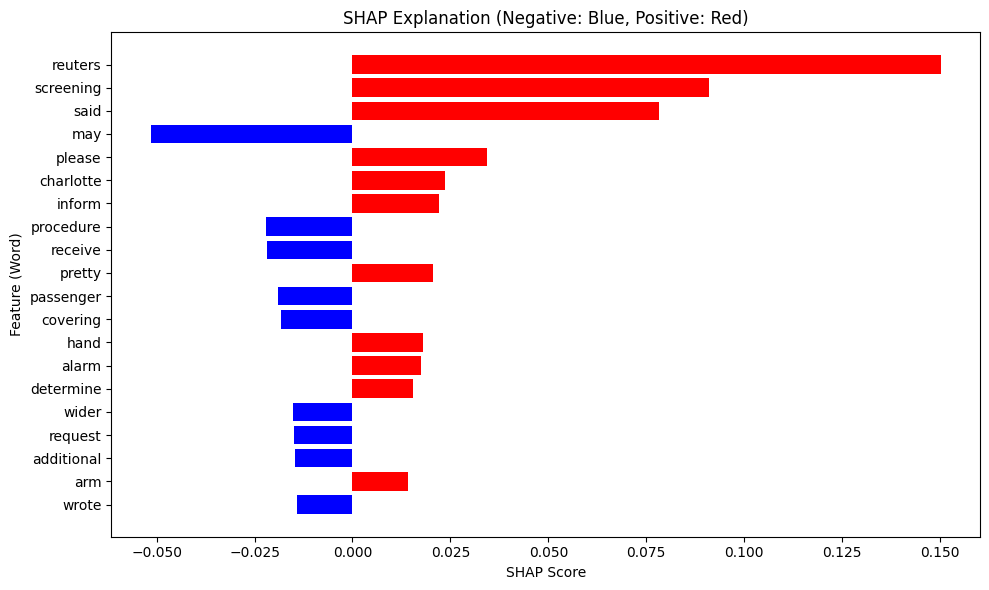

In [38]:
# Example 1
print(f"Generating SHAP features and explanations for example (preprocessed) news text beginning:\n\"{X_train.loc[4600][0:170]}...\"\n")
sorted_shap_features1, prob1 = generateSHAPExplanation(X_train, X_test, y_train, y_test, X_train.loc[4600])

In [ ]:
# Example 2
print(f"Generating SHAP features and explanations for example (preprocessed) news text beginning:\n\"{X_train.loc[58690][0:170]}...\"\n")
sorted_shap_features2, prob2 = generateSHAPExplanation(X_train, X_test, y_train, y_test, X_train.loc[58690])

Generating SHAP features and explanations for example (preprocessed) news text beginning:
"representative steve king riowa notorious racist sunday came fire xenophobic comment suggesting immigration bad america western civilization monday doubled comment even s..."

1. TF-IDF vectorizing train and test sets...
2. Training Passive Aggressive Classifier model...
3. Training CalibratedClassifierCV to map scores to probabilities...
4. Sampling background data for SHAP...
5. Converting sample text to TF-IDF vector representation...
6. Creating SHAP explainer based on sample data...
7. Calcuating SHAP values: warning - this will take a while...


  0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
sorted_shap_features2

[('civilization', 0.17844032140151428, 0.17844032140151428),
 ('via', 0.14539180107174857, 0.14539180107174857),
 ('reuters', 0.13860282897955234, 0.13860282897955234),
 ('image', 0.13596172804593087, 0.13596172804593087),
 ('racist', 0.10583782206540131, 0.10583782206540131),
 ('monday', -0.05667337620533022, 0.05667337620533022),
 ('please', 0.053437624620008506, 0.053437624620008506),
 ('king', -0.05011540863642906, 0.05011540863642906),
 ('bush', -0.04660674283812967, 0.04660674283812967),
 ('jeb', -0.04027046834275434, 0.04027046834275434),
 ('twitter', -0.03607015628714256, 0.03607015628714256),
 ('contributed', -0.03257254974368943, 0.03257254974368943),
 ('doesnt', -0.03239699745107156, 0.03239699745107156),
 ('march', -0.03140211072483636, 0.03140211072483636),
 ('relative', -0.029040846058797316, 0.029040846058797316),
 ('destiny', -0.027390442941869472, 0.027390442941869472),
 ('comment', 0.026802896140654103, 0.026802896140654103),
 ('contempt', -0.025971101555996363, 0.025

In [35]:
type(sorted_shap_features)

list

## Developing Natural Language Explanation Templates Based on Probabilities and SHAP Feature Scores

Templates should include:

1. Probability score i.e. likelihood of a text being fake news
2. Explanation of the top five words pushing the word to that classification label, sorted in descending order of importance

In [37]:
def convertSHAPInfoToNaturalLanguageExplanation(sorted_shap_features, prob):
  # Round the probability as a percentage to the nearest integer
  perc = round(prob * 100)
  probability_explanation = f"This news article has been classed as {perc}% fake news. This means it is more likely to be fake than real news."

  if prob > 0.5:
    category = "fake"
  elif prob < 0.5:
    category = "real"
  else:
    category = "neither fake nor real"

  # Words to explain prediction stored in this list
  selected_features= []

  # Iterate over the 50 top SHAP features/words to generate explanation
  for i in range(0, 50):
    shap_feature = sorted_shap_features[i]
    """
      Add to selected words for explanation if (a) SHAP feature has positive score (pushing towards fake news) AND overall prediction probability is over 0.5 (fake)
       OR (b) SHAP feature has negative score (pushing towards real news) AND overall prediction is less than 0.5 (real)
       OR  (c) probability is exactly 0.5, meaning not leaning to either real or fake
    """
    if (shap_feature[1] > 0 and prob > 0.5) or (shap_feature[1] < 0 and prob < 0.5) or (prob == 0.5): # shap_feature[1] contains the SHAP value for this word
      selected_features.append(shap_feature[0]) # Append the word to the selected_features list
    # Break out of loop once 5 most informative words extracted
    if selected_features == 5:
      break

  # Now we have the selected words, generate the explanation
  feature_explanation = f"""This prediction was generated because the following words in the example news text have more commonly be found
                            in {category} news stories in the training data. The words are ranked from highest to lowest importance
                            for making the prediction.\n{selected_features[0]}, {selected_features[1]},
                            {selected_features[2]}, {selected_features[3]}, {selected_features[4]}.
                        """

  return feature_explanation

In [ ]:
# Test on example text 1
onvertSHAPInfoToNaturalLanguageExplanation(sorted_shap_features1, prob1)

In [ ]:
# Test on example text 2
onvertSHAPInfoToNaturalLanguageExplanation(sorted_shap_features1, prob1)
